# CMS Anomaly Detection

In this experiment we build a network that consists of subnetworks linked by a Fuzzy AND.
Each subnetwork is built on features that correspond to one of the following channels:
- muons
- photons
- particle flows (PF)
- particles from calorimiter (calo)

The ultimate goal is to estimate probability of anomalies occuring in each individual channel by learning to predict global probabilities. This is done by training this network on labels of global anomalies (i.e. is anomaly present somewhere) and then defining output of each subnetwork as score for anomaly in its channel.

The justification of this approach is following.

Consider a set of channels $\mathcal{C}$ listed above and set of anomalies $\mathcal{A}$.
Each anomaly $A \in \mathcal{A}$ corresponds to a subset of channels $C \subseteq \mathcal{C}$ where this anomaly occurs. The main assumptions:
1. each possible anomaly can be detected by at least one subnetwork;
2. any classifier build on features from channels $\bar{C} = \mathcal{C} \setminus C$ can not detect anomaly $A$, e.g. anomaly in the photon channel does not change behaviour of muons.
Thus, from the prospective of detecting anomaly $A$ score of any classifier built on $\bar{C}$ is no more than an independent random variable.

The network and its loss function are defined in the way that the given anomaly $A$ loss is the lower the more subnetworks report anomaly. Since subnetworks from $\bar{C}$ in principle have no predictive power for $A$, average loss reaches its minimum close to the situation when for each kind of anomaly $A$ affecting channels $C$ subnetworks from $C$ report anomaly and the rest report no abnormalities in their channels, i.e. each subnetwork reports presence of anomaly in its channel, which is exactly the goal of this experiment.

However, this ideal result occur only when anomalies have the same weight, but due to the nature of the loss function: if at least one network reports anomaly, which is always true by assumption 1, another subnetwrok can change the score torwards anomaly only slightly. Thus any considerable bias of subnetwork torwards anomalies implies much higher losses under 'everything is good' sutiation than gain from unrelated anomalies:

$$\mathbb{E}[ \mathcal{L}(\mathrm{subnetwork} + \mathrm{bias}) - \mathcal{L}(\mathrm{subnetwork}) \mid \mathrm{no\;anomalies}] \gg \mathbb{E}[ \mathcal{L}(\mathrm{subnetwork}) - \mathcal{L}(\mathrm{subnetwork} + \mathrm{bias}) \mid \mathrm{unrelated\;anomaly}]$$

## Prepearing data

In [1]:
%env THEANO_FLAGS="device=gpu0", "gpuarray.preallocate=0.9", "floatX=float32"
import theano
import theano.tensor as T

from lasagne import *

env: THEANO_FLAGS="device=gpu0", "gpuarray.preallocate=0.9", "floatX=float32"


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import numpy as np
import pandas as pd
import cPickle as pickle
import os

import re

DATA_PATH = 'merged.pickle'
LABELS_PATH = './quality_2010/labels_v2.pickled'

/home/apanin/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from collections import defaultdict
from IPython import display
import time

The input files contains preselected features from CMS 2010B open data.
The features were generated from original root in following way:

1. There were selected 3 streams:
  - MiniBias,
  - muons,
  - photons.
2. In each stream 4 "channels" were selected:
  - muons
  - photons
  - PF (particle flows)
  - calo (calorimiter)
3. For each channel from each event  5 quantile particles were selected with redards to thier momentum: quantile $q_i$ corresponds to particle with index closest to $\frac{i}{5}N$, i.e. $q_5$ corresponds to the particle with maximal momentum.
4. Each particle is described by its physical properties: $\eta, \phi, p_T, f_x, f_y, f_z, m$
5. Physical features were aggragated by lumisections, producing:
  - 1, 25, 50, 75, 99 percentiles
  - mean and std
  
As the result each lumisection is described by percentiles, means and stds of distributions of physical features of particles of particular quantiles within particular channel within particular stream.

Some additional features were added like total momentum of all particles of particular channel within event

In [4]:
with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

with open(LABELS_PATH, 'r') as f:
    sub_labels = pickle.load(f)

labels = sub_labels['json_0.txt']

In [5]:
### technical columns
not_features = [
    '_luminosityBlock',
    '_run'
]

### columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

In [6]:
for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)

In [7]:
lumi = np.maximum(
    np.maximum(data['_instantLumi_minibias'].get_values(), data['_instantLumi_muons'].get_values()),
    data['_instantLumi_photons'].get_values()
)

nonempty = np.where(lumi > 0.0)[0]

In [8]:
data = data.iloc[nonempty]
lumi = lumi[nonempty]
labels = labels[nonempty]

for k in sub_labels:
    sub_labels[k] = sub_labels[k][nonempty]

In [9]:
lumi_bad = np.sum(lumi[labels == 0.0])
lumi_good = np.sum(lumi[labels == 1.0])

In [10]:
### By normalizing weights we implicitly define equal probabilities for each class
weights = lumi / np.where(labels == 1.0, lumi_good, lumi_bad)
weights *= lumi.shape[0]

In [11]:
w_bad = np.sum(weights[labels == 0.0])
w_good = np.sum(weights[labels == 1.0])

## Grouping features

Feature set has its own intrisic hierarchy. It can be easily seen from their names:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

In [12]:
### utility functions
def insert(keys, d, f):
    key = keys[0]

    if len(keys) == 1:
        d[key] = f
    else:
        if not d.has_key(key):
            d[key] = dict()
        return insert(keys[1:], d[key], f)

def levels(features, n_levels = 5):
    dicts = [features]

    levels = list()

    for level in range(n_levels):
        levels.append(
            set([ k for d in dicts for k in d ])
        )
    
        dicts = [ d[k] for d in dicts for k in d ]
    return levels
    
def get_feature_groups(feature_list, re_exp):
    """
    Retuns:
    1. hierachical dictionary feature groups -> feature full name
    2. feature levels
    3. unprocessed features
        
    """
    features = dict()
    rest = list()
    n_levels = set()

    for f in feature_list:
        matches = re.findall(re_exp, f)

        if len(matches) == 1:
            insert(matches[0], features, f)
            n_levels.add(len(matches[0]))
        elif len(matches) == 0:
            rest.append(f)
        else:
            raise Exception('Very suspicious feature: %s -> %s' % (f, matches))
    assert len(n_levels) == 1
    return features, levels(features, n_levels=list(n_levels)[0]), rest

In [13]:
def insert_fake_path(d, level, path = 'general'):
    if level == 0:
        return { path : d }
    else:
        r = dict()
        for k in d:
            r[k] = insert_fake_path(d[k], level - 1, path)
        
        return r

### Selecting particles' features:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

In [14]:
particle_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(q[12345])[_](\w+)')
particle_features, particle_levels, rest = get_feature_groups(features, particle_f_re)

In [15]:
for level in particle_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
phi pt fX fY fZ eta mass
q1 q3 q2 q5 q4
std p99 p1 p25 p75 p50 mean


### Selecting features that belong to a particle type:
> `<stream>_<particle type>_<physical feature>_<feature quantile>`

In [16]:
particle_type_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+([a-zA-Z0-9]+)')
particle_type_features, particle_type_levels, rest = get_feature_groups(rest, particle_type_f_re)

In [17]:
for level in particle_type_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
Pz Px Py
std p99 p1 p25 p75 p50 mean


In [18]:
particle_type_features = insert_fake_path(particle_type_features, level = 2, path='allParticles')

for level in levels(particle_type_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
allParticles
Pz Px Py
std p99 p1 p25 p75 p50 mean


The features above are components of momentum of particles of particular type (channel) within event.

### Selecting features specific to events:
> `<stream>_<physical feature>_<feature quantile>`

In [19]:
event_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(\w+)')
event_features, event_levels, rest = get_feature_groups(rest, event_f_re)

In [20]:
for level in event_levels:
    print ' '.join(list(level))

muons minibias photons
instantLumi
std p99 p1 p25 p75 p50 mean


In [21]:
f = insert_fake_path(event_features, level = 1, path='allChannels')
f = insert_fake_path(f, level = 2, path='allParticles')

event_features = f

for level in levels(event_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
allChannels
allParticles
instantLumi
std p99 p1 p25 p75 p50 mean


Which are instant luminosity of each event.

In [22]:
rest

['_instantLumi_minibias',
 '_instantLumi_muons',
 '_instantLumi_photons',
 'minibias_nEvents',
 'minibias_nonZeroWeights',
 'muons_nEvents',
 'muons_nonZeroWeights',
 'photons_nEvents',
 'photons_nonZeroWeights']

### And finally features specific to lumisection itself:
> `<stream>_<physical feature>_<feature quantile>`

In [23]:
stream_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)')
stream_features, stream_levels, rest = get_feature_groups(rest, stream_f_re)

In [24]:
for level in stream_levels:
    print ' '.join(list(level))

muons minibias instantLumi photons
muons nEvents photons nonZeroWeights minibias


Number of events and fration of non-zero features for lumisection (all NA's are replaced with zeros).

In [25]:
rest

[]

In [26]:
def flatten(a_dict):
    for k in a_dict:
        if hasattr(a_dict[k], 'keys'):
            for path, value in flatten(a_dict[k]):
                yield (k, ) + path, value
        else:
            yield (k, ), a_dict[k]

def merge(dicts):
    result = dict()
    for d in dicts:
        for path, value in flatten(d):
            insert(path, result, value)

    return result

def flatten_dict(d):
    r = dict()
    for paths, v in flatten(d):
        k = '_'.join(paths)
        r[k] = v
    return r

def squezze(d, depth = 5, last=2):
    dc = d.copy()

    if depth - 1 == last:
        for k in d:
            dc[k] = flatten_dict(d[k])
        
        return d
    else:
        for k in d:
            dc[k] = squezze(d[k], depth-1, last)
        
        return dc

def group(d, level=2):
    gd = defaultdict(lambda: list())
    for path, k in flatten(d):
        gk = path[:level]
        gd[gk].append(k)
    
    return gd

In [27]:
feature_hierarchy = merge([
    particle_features, particle_type_features, event_features
])

All features are grouped by stream-channel.

In [28]:
grouped = group(feature_hierarchy, level=2)

In [29]:
[ (g, len(fs)) for g, fs in grouped.items() ]

[((u'muons', u'photons'), 231),
 ((u'minibias', u'PF'), 126),
 ((u'photons', u'photons'), 231),
 ((u'minibias', u'calo'), 266),
 ((u'muons', u'muons'), 266),
 ((u'photons', u'muons'), 266),
 ((u'minibias', 'allChannels'), 7),
 ((u'photons', u'calo'), 266),
 ((u'photons', u'PF'), 126),
 ((u'muons', u'PF'), 126),
 ((u'minibias', u'photons'), 231),
 ((u'muons', 'allChannels'), 7),
 ((u'photons', 'allChannels'), 7),
 ((u'minibias', u'muons'), 266),
 ((u'muons', u'calo'), 266)]

For this experiment only the following groups are used:
- muons from muon stream
- photons from photon stream
- Particle Flows from minibias stream
- calo particles from minibias stream

In [30]:
channels_features = dict()

for k in [('muons', 'muons'), ('photons', 'photons'), ('minibias', 'PF'), ('minibias', 'calo')]:
    channels_features[k[1]] = grouped[k]

In [31]:
channels_features['muons'].append('_instantLumi_muons')
channels_features['photons'].append('_instantLumi_photons')

In [32]:
[ (g, len(fs)) for g, fs in channels_features.items() ]

[('muons', 267), ('photons', 232), ('PF', 126), ('calo', 266)]

In [33]:
subsytem_descriptions = dict(
    [
        ('json_0.txt', 'inclusive global label')
    ] + [
        ('json_%d.txt' % i, desc)
        for i, desc in zip(range(15, 23), [
            '15:DQM: Rpc GOOD,\nDCS: Rpc',
            '16:DQM: Csc GOOD,\nDCS: Csc',
            '17:DQM: Dt GOOD,\nDCS: Dt',
            '18:DQM: Hcal GOOD,\nDCS: Hcal',
            '19:DQM: Ecal GOOD,\nDCS: Ecal',
            '20:DQM: Es GOOD,\nDCS: Es',
            '21:DQM: Strip GOOD,\nDCS: Strip',
            '22:DQM: Pix GOOD,\nDCS: Pix'
        ])
    ] + [
        ('json_%d.txt' % i, desc)
        for i, desc in zip(range(11, 15) + range(23, 25), [
            '11: DQM: Muon GOOD,\nDCS: Strip, Pix, Dt, Rpc, Csc on',
            '12: DQM: Jmet GOOD,\nDCS: Ecal, Hcal on',
            '13: DQM: Egam GOOD,\nDCS: Strip, Pix, Ecal on',
            '14: DQM: Track GOOD,\nDCS: Strip, Pix on',
            '23: DQM: Hlt GOOD,\nDCS: Strip, Pix, Ecal on',
            '24: DQM: L1t GOOD,\nDCS: none'
        ])
    ]
)

## Building netwrok

In [34]:
### For simplicity each feature group is put into its own shared variable.
shareds = {}

for k in channels_features:
    features = channels_features[k]

    shareds[k] = theano.shared(
        data[features].get_values().astype('float32'),
        name = 'X %s' % k
    )

In [35]:
labels_shared = theano.shared(labels.astype('float32'), 'labels')
weights_shared = theano.shared(weights.astype('float32'), 'weights')

In [36]:
batch_indx = T.ivector('batch indx')

In [37]:
def batch_stream(X, batch_size=32):
    indx = np.random.permutation(X.shape[0])
    n_batches = X.shape[0] / batch_size

    for i in xrange(n_batches):
        batch_indx = indx[(i * batch_size):(i * batch_size + batch_size)]
        yield X[batch_indx]

For each feature group we build a dense neural network.
On the one hand, a network should be capable of capturing non-trivial anomalies,
on the other hand a number of training samples is small. It is the reason why heavy dropout is applied for each layer.

Nevertheless, we should expect low bias due to dropout, since it is believed that not all features should interact
directly within one unit. For example, it is reasonable that momentum features do not mix with angular ones within one unit. Thus structure of weights should be sparse, which is one of the effects of the dropout regularization.

In [38]:
def build_network(shared, batch_indx, num_units = (50, 10), n_dropout=2, p_dropout=0.25):
    n_features = shared.get_value().shape[1]
    X_batch = shared[batch_indx]

    input_layer = layers.InputLayer(shape=(None, n_features), input_var=X_batch)
    net = input_layer
    
    net = layers.DropoutLayer(net, p=0.1, rescale=False)
    
    for i, n in enumerate(num_units):
        net = layers.DenseLayer(net, num_units=n, nonlinearity=nonlinearities.sigmoid)
        if i < n_dropout:
            net = layers.DropoutLayer(net, p=p_dropout, rescale=True)
    
    net = layers.DenseLayer(net, num_units=1, nonlinearity=nonlinearities.sigmoid)
    
    det_prediction = T.flatten(layers.get_output(net, deterministic=True))
    train_prediction = T.flatten(layers.get_output(net, deterministic=False))
    
    return net, det_prediction, train_prediction

In [39]:
networks = {}
det_predictions = {}
train_predictions = {}

for k in shareds:
    shared = shareds[k]

    net, det_prediction, train_prediction = build_network(shared, batch_indx, num_units=(100, 50, 20), p_dropout=0.25)
    
    det_predictions[k] = det_prediction
    train_predictions[k] = train_prediction

    networks[k] = net

In [40]:
get_get_predictions = {}
get_stochastic_predictions = {}

for k in det_predictions:
    get_get_predictions[k] = theano.function([batch_indx], det_predictions[k])
    get_stochastic_predictions[k] = theano.function([batch_indx], train_predictions[k])

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


In [41]:
labels_batch = labels_shared[batch_indx]
weights_batch = weights_shared[batch_indx]

In [42]:
reg = reduce(lambda a, b: T.maximum(a, b), [
    regularization.regularize_network_params(networks[k], penalty=regularization.l2)
    for k in networks
])

In [43]:
def fuzzy_and(args):
    s = reduce(lambda a, b: a + b, args)
    return T.exp(s - 4.0)

train_global_prediction = fuzzy_and(train_predictions.values())
det_global_prediction = fuzzy_and(det_predictions.values())

In [44]:
c_reg = T.fscalar('c reg')
learning_rate = T.fscalar('learning rate')

coef_loss = theano.shared(np.array(0.7, dtype=theano.config.floatX)) #constant to regulate amount of “pretraining”
decay = np.array(0.8, dtype=theano.config.floatX) #to decrease coef_loss

In [64]:
log_losses = -((1 - labels_batch) * T.log(1 - train_global_prediction) + labels_batch * T.log(train_global_prediction))

pure_loss = T.mean(weights_batch * log_losses)

loss = pure_loss +  c_reg * reg

pure_losses = {}
for k in networks:
    log_loss = -((1 - labels_batch) * T.log(1 - train_predictions[k]) + labels_batch * T.log(train_predictions[k]))
    pure_losses[k] = T.mean(weights_batch * log_loss)

modified_loss = (1 - coef_loss)*loss + coef_loss*np.sum(pure_losses[k] for k in networks)/4.

Modified loss function to accelerate convergence is used:

$ L' = (1-C) * L + C * (L_1 + L_2 + L_3 + L_4) / 4 $,

where:  $L$ - old loss (cross-entropy for “fuzzy AND” output),
$L_i$ - 'companion' losses, $C$ - constant to regulate amount of “pretraining” ($C$ ~ 1, $C$ < 1).

Companion losses can be cross-entropy of corresponding subnetwork scores against global labels. So it is simillar to the pretraining of separate networks on global labels. This losses force separate subnetworks to participate more in final prediction when the training process at the beginning.

Every $k$ epochs constant C is decreased, and ensemble performance becomes determinant. So we allow some anomalies not be seen from each channel, in this way ensemble loss heps not to overfit at the end and to obtain simple hyperplane.

In [46]:
params = reduce(lambda a, b: a + b, [
        layers.get_all_params(net)
        for net in networks.values()
])

upd = updates.adam(modified_loss, params, learning_rate = learning_rate)

In [47]:
train = theano.function([batch_indx, c_reg, learning_rate], [modified_loss, pure_loss], updates=upd)
get_loss = theano.function([batch_indx], pure_loss)

get_prediction = theano.function([batch_indx], det_global_prediction)
get_train_prediction = theano.function([batch_indx], train_global_prediction)

In [48]:
indx_train, indx_test = train_test_split(np.arange(data.shape[0], dtype='int32'), stratify=labels, test_size=0.1, random_state = 1)

In [ ]:
n_epoches = 801
batch_size = 63
n_batches = indx_train.shape[0] / batch_size
lr = 2e-3
c_reg = 6.0e-7

pure_losses = np.zeros(shape=(2, n_epoches), dtype='float32')
validation_losses = np.zeros(shape=(len(networks)+1, n_epoches), dtype='float32')

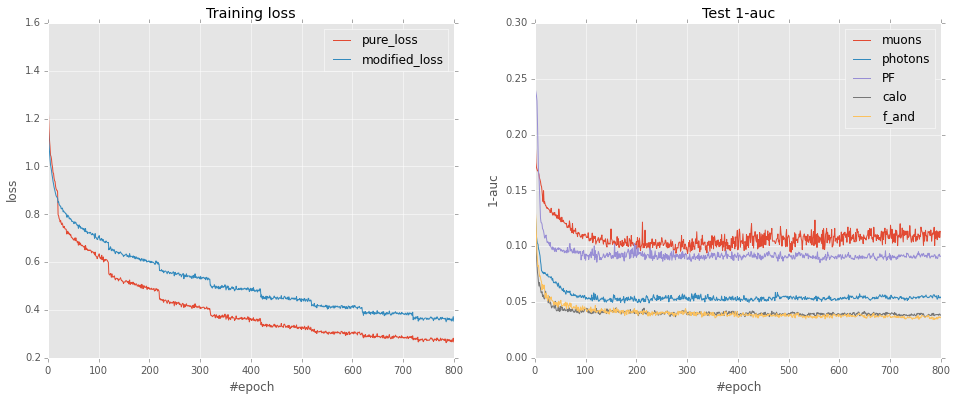

In [52]:
for epoch in xrange(0,n_epoches):
    if epoch%100 == 0:   
        #save the network's weights
        netInfo  = {}
        for net in networks:
            netInfo['network '+str(net)] = networks[net]
            netInfo['params '+str(net)] =  layers.get_all_param_values(networks[net])
        Net_FileName = 'pretraining_loss_'+str(epoch)+'.pkl'
        pickle.dump(netInfo, open(os.path.join('models/', Net_FileName), 'wb'),protocol=pickle.HIGHEST_PROTOCOL)
        #decrease learning rate and amount of 'pretraining' loss
    if epoch%100 == 20:    
        coef_loss.set_value(coef_loss.get_value() * decay)
        lr = lr*0.8
        
    batch_loss_m = 0.
    batch_loss_p = 0.
    for i, idx in enumerate(batch_stream(indx_train, batch_size=batch_size)):
        mod, pure = train(idx, c_reg, lr)
        batch_loss_m += mod
        batch_loss_p += pure
    pure_losses[0,epoch] = batch_loss_p/n_batches
    pure_losses[1,epoch] = batch_loss_m/n_batches
    
    sum_pred_test = np.zeros((len(indx_test)))   
    for k, net in enumerate(networks):       
        prediction_net = get_get_predictions[net](indx_test)
        sum_pred_test += prediction_net
        validation_losses[k,epoch] = 1 - roc_auc_score(
            labels[indx_test],
            prediction_net,
            sample_weight=weights[indx_test]) 
    f_and = np.exp(sum_pred_test - 4.)   
    validation_losses[k+1,epoch] = 1 - roc_auc_score(labels[indx_test],f_and,sample_weight=weights[indx_test]) 
    
    #plots
    display.clear_output(wait=True)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
        
    axes[0].set_title("Training loss")
    axes[0].set_xlabel("#epoch")
    axes[0].set_ylabel("loss")
    for n in range(2):
        axes[0].plot(pure_losses[n][:(epoch + 1)])
    axes[0].legend(['pure_loss', 'modified_loss'], loc = 'best')
    
    axes[1].set_title("Test 1-auc")
    axes[1].set_xlabel("#epoch")
    axes[1].set_ylabel("1-auc")
    for n in range(5):
        axes[1].plot(validation_losses[n][:(epoch + 1)])
    axes[1].legend(networks.keys()+['f_and'], loc = 'best')
    plt.show()



In [53]:
epoch

800

In [ ]:
# Net_FileName = 'modified_loss_'+str(900)+'.pkl'
# netInfoload = pickle.load(open(os.path.join('models/',Net_FileName),'rb'))
# for net in networks:
#     layers.set_all_param_values(networks[net], netInfoload['params '+str(net)]) 

# Performance plots

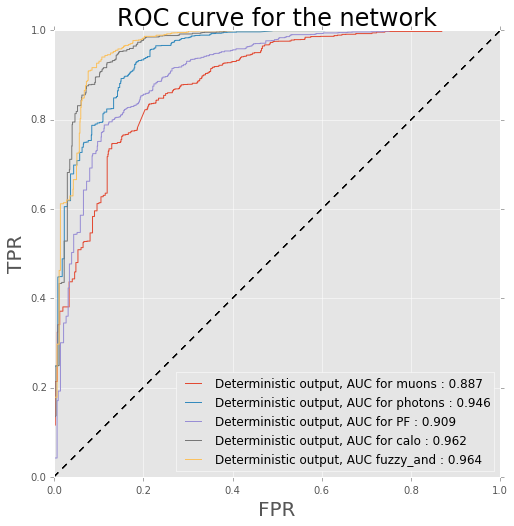

In [54]:
plt.figure(figsize=(8, 8))

sum_pred = np.zeros((len(indx_test)))
log_and = np.ones((len(indx_test)))
for k in networks.keys():
    common_proba = get_get_predictions[k](indx_test)
    sum_pred += common_proba
    log_and*= common_proba


    plt.plot([0, 1], [0, 1], '--', color='black')

    fpr, tpr, _ = roc_curve(labels[indx_test], common_proba, sample_weight=weights[indx_test])
    auc_score = auc(fpr, tpr, reorder=True)
    plt.plot(fpr, tpr, label='Deterministic output, AUC for %s : %.3lf' % (k, auc_score))

f_and = np.exp(sum_pred - 4.)

fpr, tpr, _ = roc_curve(labels[indx_test], f_and, sample_weight=weights[indx_test])
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='Deterministic output, AUC fuzzy_and : %.3lf' % auc_score)


plt.legend(loc='lower right')
plt.title('ROC curve for the network', fontsize=24)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.show()

In [55]:
probas = {}

for k in networks.keys():
    feautures = channels_features[k]
    probas[k] = get_get_predictions[k](indx_test)

/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


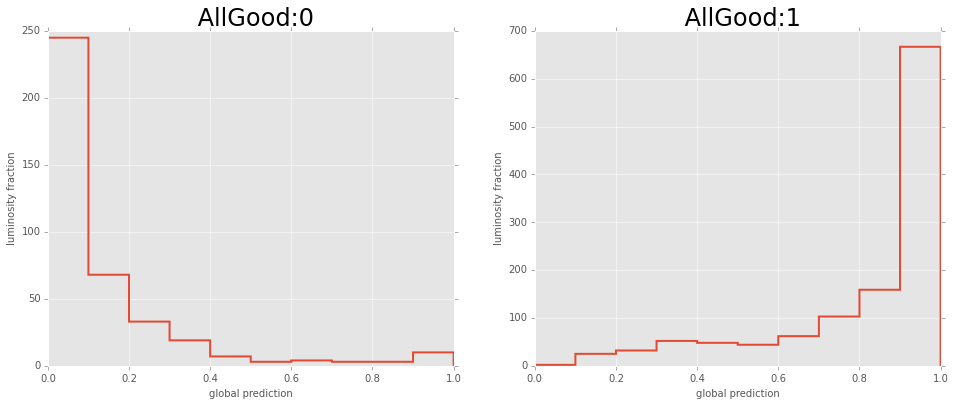

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for j, allgood in enumerate(np.array([0,1])): 
    where_allgood = np.where(sub_labels['json_0.txt'][indx_test] == allgood)[0]

    axes[j].hist(f_and[where_allgood], bins=10, range=(0, 1),
                         histtype='step', lw=2)
    axes[j].legend(loc='upper center')
    axes[j].set_title(' AllGood:'+ str(allgood),  fontsize=24)
    axes[j].set_ylabel('luminosity fraction', fontsize=10)
    axes[j].set_xlabel(r'global prediction', fontsize=10)
plt.show()   

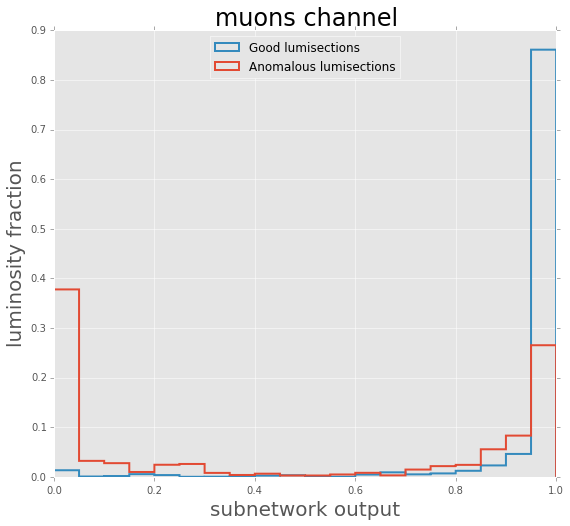

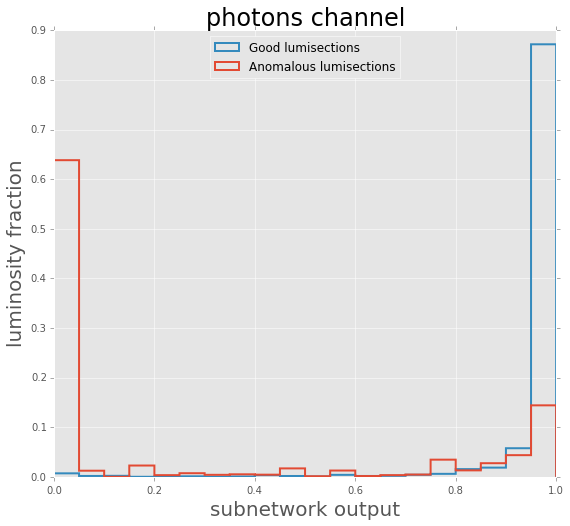

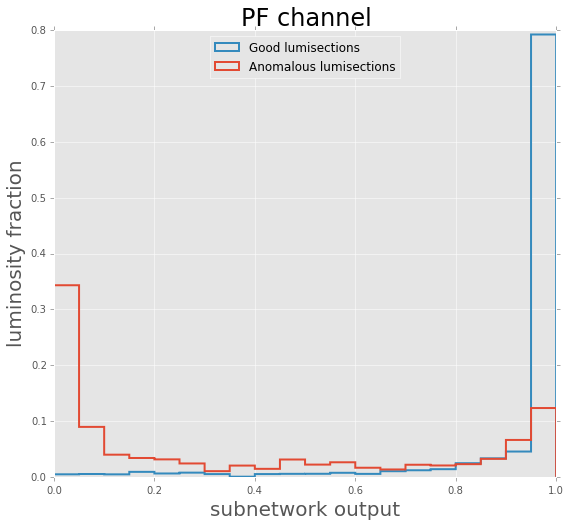

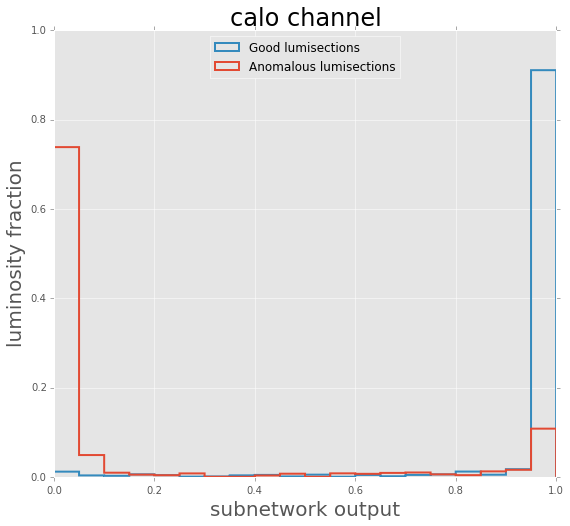

In [57]:
for k in networks.keys():
    proba = probas[k]
    
    plt.figure(figsize=(9, 8))
    plt.hist([
            proba[labels[indx_test] == 0.0],
            proba[labels[indx_test] == 1.0]
    ],bins=20, range=(0, 1), weights=[
        weights[indx_test][labels[indx_test] == 0.0] / np.sum(weights[indx_test][labels[indx_test] == 0.0]),
        weights[indx_test][labels[indx_test] == 1.0] / np.sum(weights[indx_test][labels[indx_test] == 1.0])
    ], histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=2)
    plt.legend(loc='upper center')
    plt.title('%s channel' % k, fontsize=24)
    plt.ylabel('luminosity fraction', fontsize=20)
    plt.xlabel(r'subnetwork output', fontsize=20)
    plt.show()

/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


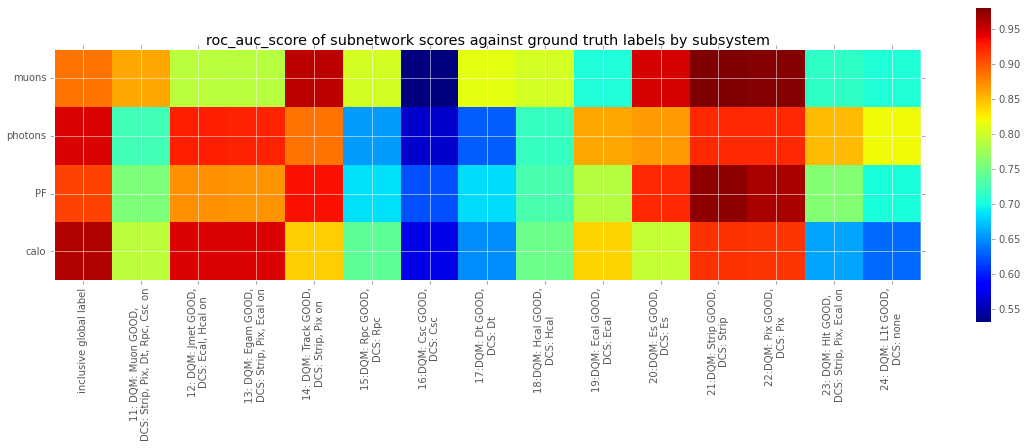

In [58]:
metric = roc_auc_score
met_name = 'roc_auc_score'



channels = networks.keys()
sub_systems = sorted(sub_labels.keys())

aucs = np.ones(shape=(len(channels), len(sub_systems))) / 2.0

for i, channel in enumerate(channels):
    for j, sub_system in enumerate(sub_systems):
        try:
            aucs[i, j] = metric(sub_labels[sub_system][indx_test], probas[channel], sample_weight=weights[indx_test])
        except Exception as e:
            print e
            
            
fig = plt.figure(figsize=(16, 7))

im = plt.imshow(aucs, interpolation='None', aspect=1)
plt.colorbar(im, shrink=0.75)


plt.xticks(np.arange(len(sub_systems)), [subsytem_descriptions[k] for k in sub_systems], rotation=90)
plt.yticks(np.arange(4), [ "%s" % g for g in channels ])
plt.title(str(met_name)+' of subnetwork scores against ground truth labels by subsystem')

plt.tight_layout()

plt.show()

With “Soft pretraining” scheme of learning NN we got all ROC AUC scores > 0.5. So there is no anticorrelations as it was expected.

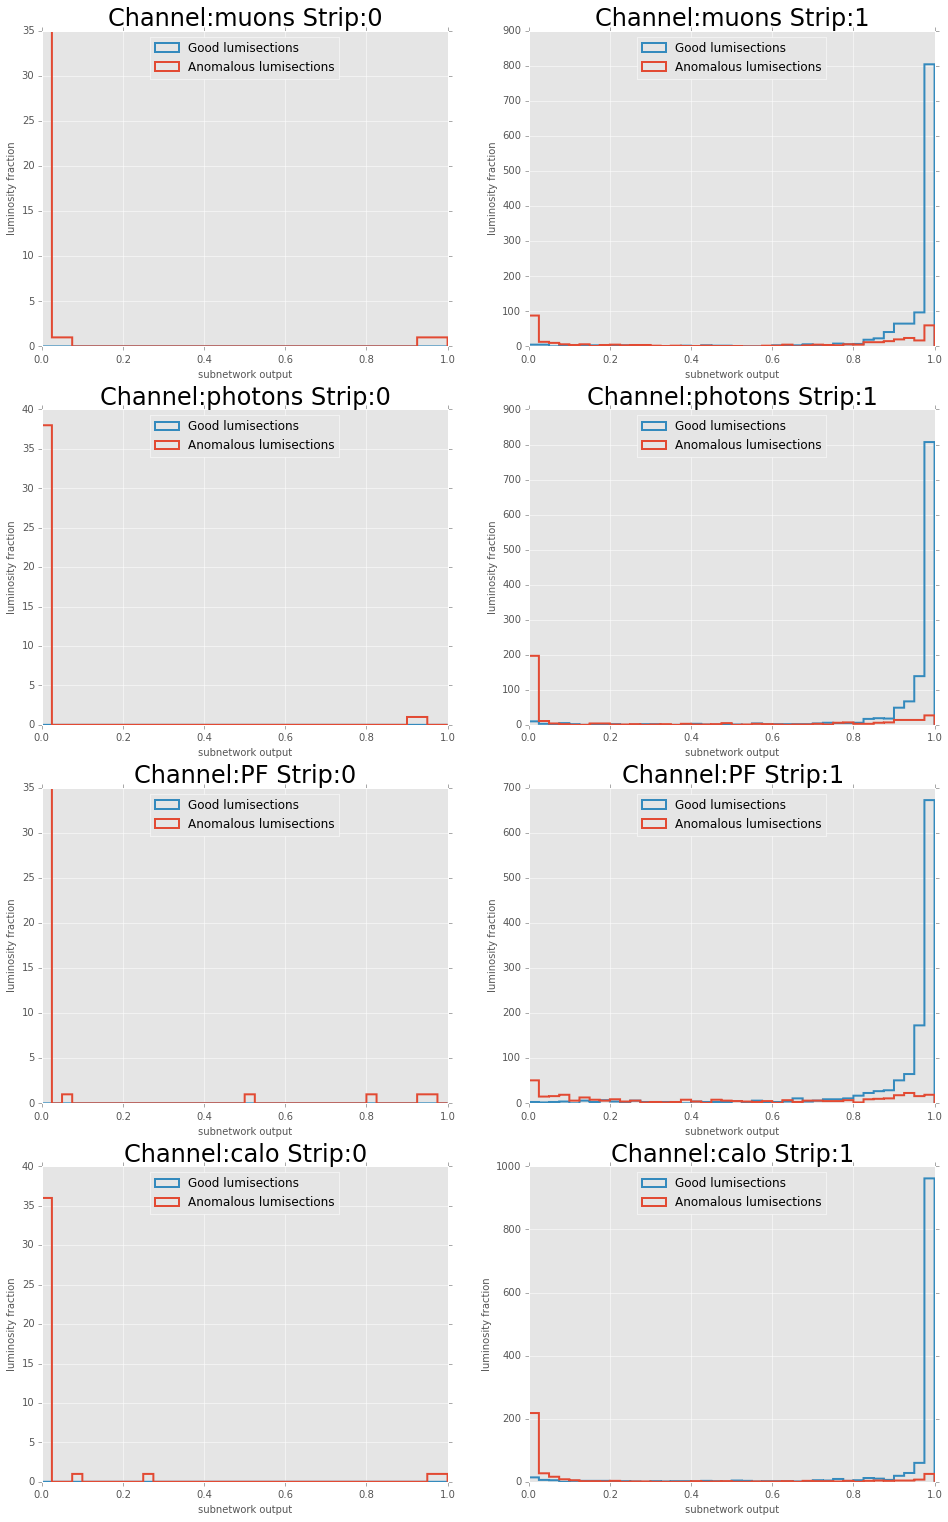

In [60]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 26))
for j, strip in enumerate(np.array([0,1])):    
    for i, k in enumerate(channels):
        proba = probas[k]
        where_strip = np.where(sub_labels['json_21.txt'][indx_test] == strip)[0]

        axes[i,j].hist([
                proba[where_strip][labels[indx_test][where_strip] == 0.0],
                proba[where_strip][labels[indx_test][where_strip] == 1.0]
        ],bins=40, range=(0, 1), 
#         weights=[
#             weights[indx_test][where_strip][labels[indx_test][where_strip] == 0.0] / np.sum(weights[indx_test][where_strip][labels[indx_test][where_strip] == 0.0]),
#             weights[indx_test][where_strip][labels[indx_test][where_strip] == 1.0] / np.sum(weights[indx_test][where_strip][labels[indx_test][where_strip] == 1.0])],
          histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=2)
        axes[i,j].legend(loc='upper center')
        axes[i,j].set_title('Channel:' + str(k)+' Strip:'+ str(strip),  fontsize=24)
        axes[i,j].set_ylabel('luminosity fraction', fontsize=10)
        axes[i,j].set_xlabel(r'subnetwork output', fontsize=10)
plt.show()

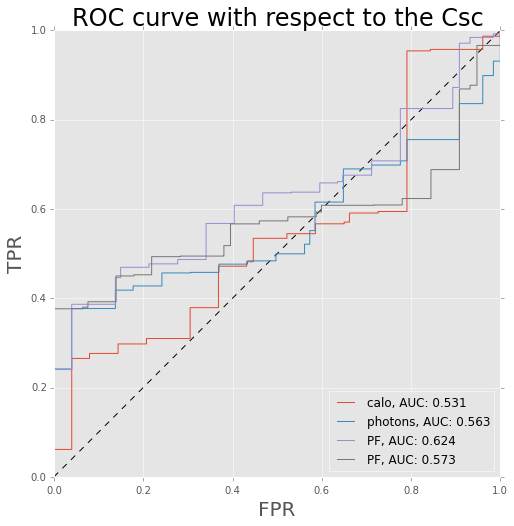

In [61]:
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], '--', color='black')

fpr, tpr, _ = roc_curve(sub_labels['json_16.txt'][indx_test], probas['muons'], sample_weight=weights[indx_test])
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='calo, AUC: %.3lf' % auc_score)


fpr, tpr, th = roc_curve(sub_labels['json_16.txt'][indx_test], probas['photons'], sample_weight=weights[indx_test])
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='photons, AUC: %.3lf' % auc_score)

fpr, tpr, th = roc_curve(sub_labels['json_16.txt'][indx_test], probas['PF'], sample_weight=weights[indx_test], drop_intermediate=True)
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='PF, AUC: %.3lf' % auc_score)

fpr, tpr, th = roc_curve(sub_labels['json_16.txt'][indx_test], probas['calo'], sample_weight=weights[indx_test], drop_intermediate=True)
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='PF, AUC: %.3lf' % auc_score)

plt.legend(loc='lower right')
plt.title('ROC curve with respect to the Csc', fontsize=24)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.show()

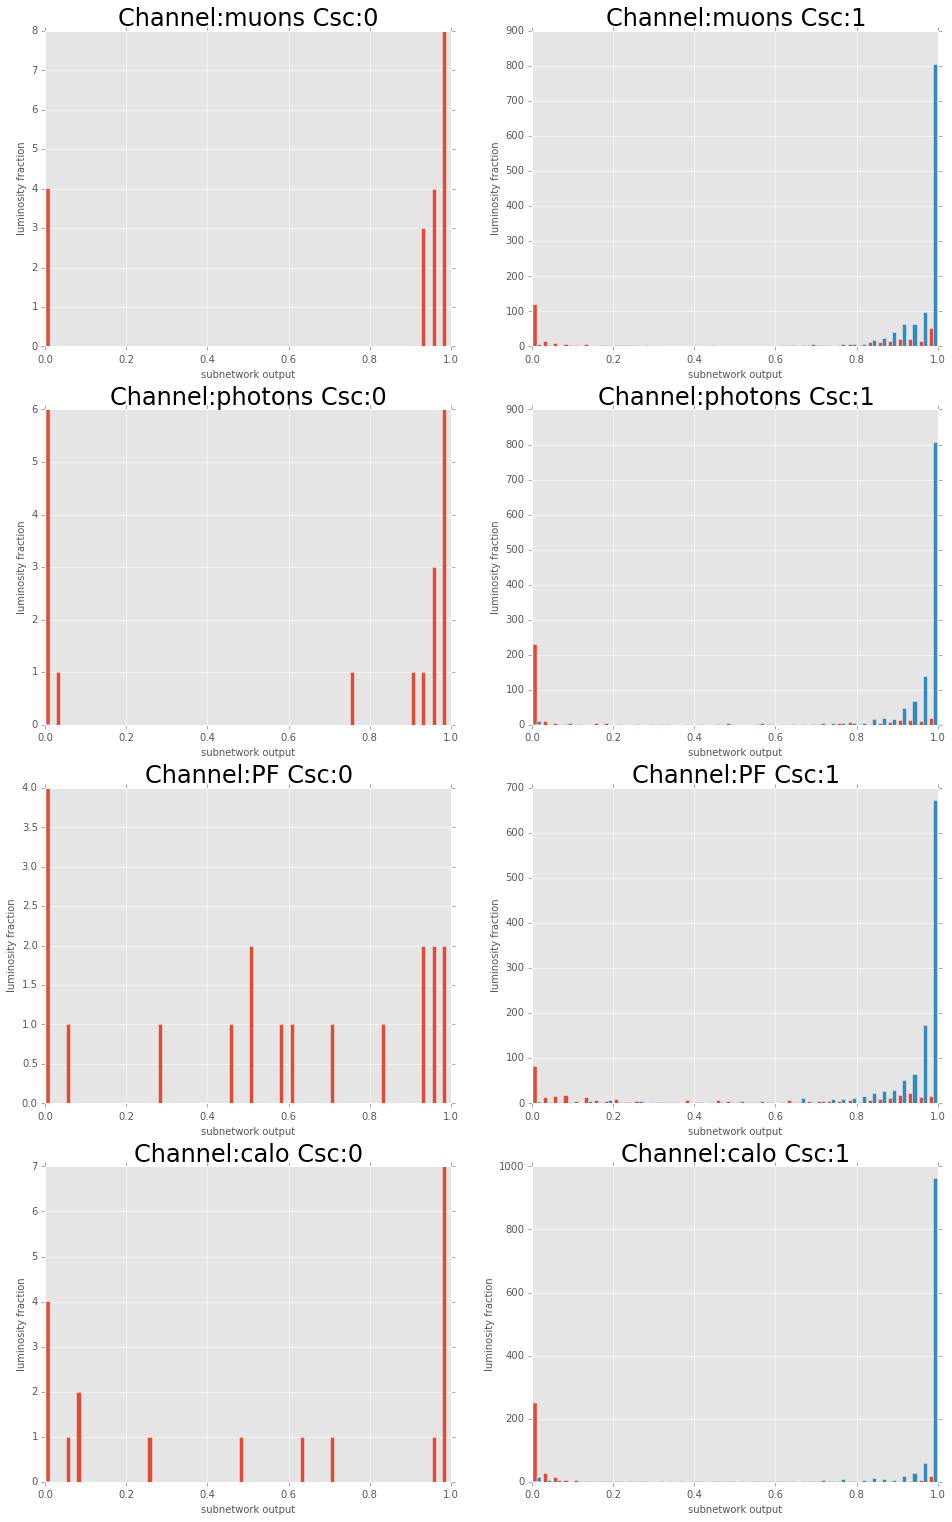

In [66]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 26))
for j, strip in enumerate(np.array([0,1])):    
    for i, k in enumerate(channels):
        proba = probas[k]
        where_strip = np.where(sub_labels['json_16.txt'][indx_test] == strip)[0]

        axes[i,j].hist([
                proba[where_strip][labels[indx_test][where_strip] == 0.0],
                proba[where_strip][labels[indx_test][where_strip] == 1.0]
        ],bins=40, range=(0, 1)) 
#         weights=[
#             weights[indx_test][where_strip][labels[indx_test][where_strip] == 0.0] / np.sum(weights[indx_test][where_strip][labels[indx_test][where_strip] == 0.0]),
#             weights[indx_test][where_strip][labels[indx_test][where_strip] == 1.0] / np.sum(weights[indx_test][where_strip][labels[indx_test][where_strip] == 1.0])],
#                 histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=2)
        axes[i,j].legend(loc='upper center')
        axes[i,j].set_title('Channel:' + str(k)+' Csc:'+ str(strip),  fontsize=24)
        axes[i,j].set_ylabel('luminosity fraction', fontsize=10)
        axes[i,j].set_xlabel(r'subnetwork output', fontsize=10)
plt.show()